In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pstats
from sklearn.linear_model import LinearRegression

# Code profiles of NCMC after a code optimisation
**Comparing timings 2 propagation kernels: velocity Verlet and GHMC**

The timings are for a salt insertion attempt in a $20 \times 20 \times 20 \text{ Angs.}^3$ periodic box of TIP3P water. Long range electrostatics treated with PME with a 9 Angs. cutoff. The water box was made with `openmmtools` `WaterBox` test system with the default switching function for LJ interactions.

Every insertion used 100 perturbation steps, different numbers of MD propagation steps were explored.

* Velocity Verlet integrator taken from `openmmtools  0.8.2 dev`
* GHMC integrator based on a modification of the GHMC integrator in  `openmmtools  0.8.2 dev`
* Simulations were run with `openmm 7.0.1`
* All simulations run with a `gtxtitanx`


**Optimisation**
- Precalculated pertubation path during class initialisation instead of during NCMC
- Initial potential energy taken from GHMC integrator
- GHMC integrator optimised by John Chodera
- Units stripped from non-bonded force parameters
- Unit manipulations reduced in energy calculations

## Timings for 100 perturbation kernels
## 1 propagation kernel for each perturbation

Reading in data:

In [2]:
repeats = 3

totaltime_ghmc = []
updateforce_ghmc = []
getenergy_ghmc = []
updateparmscont_ghmc = []
setparams_ghmc = []
ncmc_ghmc = []
step_ghmc = []

totaltime_vv = []
updateforce_vv = []
getenergy_vv = []
updateparmscont_vv = []
setparams_vv = []
ncmc_vv = []
step_vv = []

# GHMC
for rep in range(repeats):
    filename = "GHMC/profile{0}_npert100_nprop1".format(rep)
    p = pstats.Stats(filename)
    p.strip_dirs()
    p.sort_stats('cumulative')
    totaltime_ghmc.append(p.stats[('<string>', 1, '<module>')][3])
    updateforce_ghmc.append(p.stats[('saltswap.py', 613, 'updateForces')][3] )
    getenergy_ghmc.append(p.stats[('saltswap.py', 724, 'getPotEnergy')][3])
    updateparmscont_ghmc.append(p.stats[('openmm.py', 8444, 'updateParametersInContext')][3])
    setparams_ghmc.append(p.stats[('openmm.py', 8275, 'setParticleParameters')][3])
    ncmc_ghmc.append(p.stats[('saltswap.py', 512, 'NCMC')][3])
    step_ghmc.append(p.stats[('openmm.py', 5384, 'step')][3])
totaltime_ghmc = np.array(totaltime_ghmc).mean()

# velocity Verlet
for rep in range(repeats):
    filename = "velocityVerlet/profile{0}_npert100_nprop1".format(rep)
    p = pstats.Stats(filename)
    p.strip_dirs()
    p.sort_stats('cumulative')
    totaltime_vv.append(p.stats[('<string>', 1, '<module>')][3])
    updateforce_vv.append(p.stats[('saltswap.py', 613, 'updateForces')][3] )
    getenergy_vv.append(p.stats[('saltswap.py', 741, '_compute_log_probability')][3])
    updateparmscont_vv.append(p.stats[('openmm.py', 8444, 'updateParametersInContext')][3])
    setparams_vv.append(p.stats[('openmm.py', 8275, 'setParticleParameters')][3])
    ncmc_vv.append(p.stats[('saltswap.py', 512, 'NCMC')][3])
    step_vv.append(p.stats[('openmm.py', 15000, 'step')][3])
totaltime_vv = np.array(totaltime_vv).mean()

#print 'Total time for using GHMC = {0}s, Total time for vV = {1}s'.format(round(totaltime_ghmc,2),round(totaltime_vv,2))

Printing summary table showing the main differences between the NCMC steps with GHMC and velocity Verlet. 

In [3]:
print 'Timings for each stage/function for a single insertion/deletion attempt with 100 perturbation kernels, with 1 single MD step per perturbation\n'
print 'Differences between integrators shown first, followed by timings that should be the same between the two integrators.\n'
print '                      | GHMC     | velocity Verlet'
print '--------------------------------------------------'
print 'Total time            | {0:f} | {1:f}'.format(np.array(totaltime_ghmc).mean(),np.array(totaltime_vv).mean())
print 'NCMC function         | {0:f} | {1:f}'.format(np.array(ncmc_ghmc).mean(),np.array(ncmc_vv).mean())
print 'MD steps in NCMC      | {0:f} | {1:f}'.format(np.array(step_ghmc).mean(),np.array(step_vv).mean())
print 'Get Energy            | {0:f} | {1:f}'.format(np.array(getenergy_ghmc).mean(),np.array(getenergy_vv).mean())
print '--------------------------------------------------'
print 'updateParamsInContext | {0:f} | {1:f}'.format(np.array(updateparmscont_ghmc).mean(),np.array(updateparmscont_vv).mean())
print 'updateForces          | {0:f} | {1:f}'.format(np.array(updateforce_ghmc).mean(),np.array(updateforce_vv).mean())
print 'setParticleParameters | {0:f} | {1:f}'.format(np.array(setparams_ghmc).mean(),np.array(setparams_vv).mean())

Timings for each stage/function for a single insertion/deletion attempt with 100 perturbation kernels, with 1 single MD step per perturbation

Differences between integrators shown first, followed by timings that should be the same between the two integrators.

                      | GHMC     | velocity Verlet
--------------------------------------------------
Total time            | 0.291592 | 0.114417
NCMC function         | 0.276074 | 0.096296
MD steps in NCMC      | 0.140480 | 0.025422
Get Energy            | 0.065904 | 0.005196
--------------------------------------------------
updateParamsInContext | 0.060570 | 0.061354
updateForces          | 0.003259 | 0.003783
setParticleParameters | 0.001115 | 0.001166


The differences between the total times for GHMC and velocity Verlet integrator are due to 
1. The larger amount of time it takes for a single step of MD
2. The increased number of energy calls made by GHMC to calculate the protocol work

**Notes**
* Using a GHMC integrator in NCMC takes about twice as long as using velocity Verlet, but acceptance probabilities are about 5 times larger with GHMC.
    - Still worth using GHMC
* The function `updateForces` linearly interpolates between the non-bonded parameters of the ions and waters. It calls `setParticleParameters`, which is unaviodable in the current set-up.
    - `updateForces` is far too slow. Can be easly improved by pre-calculating the interpolations, instead of doing so at each insertion/deletion

In addition to the overhead for setting the parameters, there is also an overhead in the integrator, investigated below.

# Overhead in openmm's integrator step

When running a propagation step for the first time with a new set of updated parameters, there is an additional overhead, which is demonstrated and calculated below.

## Timings for 100 perturbation kernels
### Multiple propagation kernels for each perturbation

Reading data again:

In [4]:
repeats = 3

step_ghmc = []
step_vv = []

# GHMC
for nsteps in range(1,11):
    temp = []
    for rep in range(repeats):
        filename = "GHMC/profile{0}_npert100_nprop{1}".format(rep,nsteps)
        p = pstats.Stats(filename)
        p.strip_dirs()
        p.sort_stats('cumulative')
        temp.append(p.stats[('openmm.py', 5384, 'step')][3])   
    step_ghmc.append(np.array(temp).mean())
# velocity Verlet
for nsteps in range(1,11):
    temp = []
    for rep in range(repeats):
        filename = "velocityVerlet/profile{0}_npert100_nprop{1}".format(rep,nsteps)
        p = pstats.Stats(filename)
        p.strip_dirs()
        p.sort_stats('cumulative')
        temp.append(p.stats[('openmm.py', 15000, 'step')][3])   
    step_vv.append(np.array(temp).mean())

step_ghmc = np.array(step_ghmc)
step_vv = np.array(step_vv)

Looking at the total time for $n$ propagation steps, divided by the $n$. If there was no overhead for the first step, this value would be a constant. 

/Users/rossg/miniconda2/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


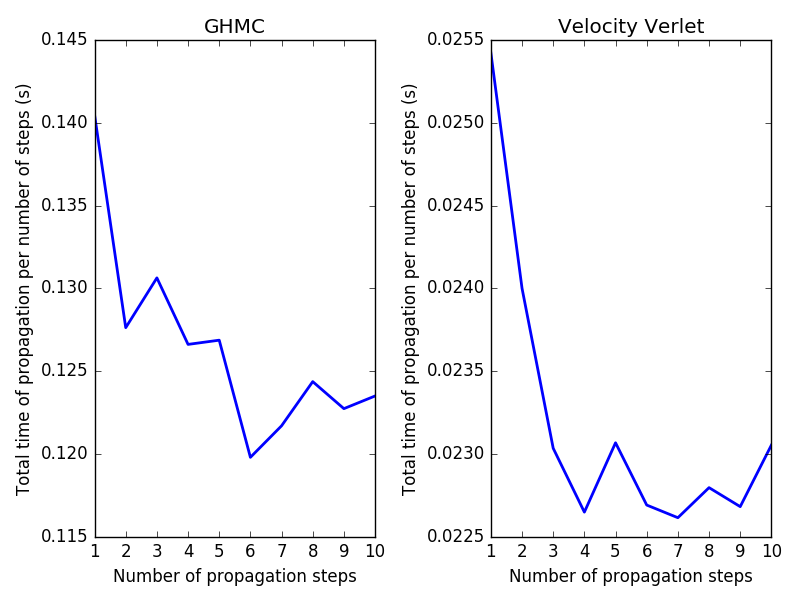

In [5]:
nsteps = np.array(range(1,11))

plt.clf()
fig, axarr = plt.subplots(1, 2)

nsteps = np.array(range(1,11))
# GHMC
axarr[0].plot(nsteps,step_ghmc/nsteps,linewidth=2)
axarr[0].set_xlabel('Number of propagation steps')
axarr[0].set_ylabel('Total time of propagation per number of steps (s)')
axarr[0].set_title('GHMC')
# velocity Verlet
axarr[1].plot(nsteps,step_vv/nsteps,linewidth=2)
axarr[1].set_xlabel('Number of propagation steps')
axarr[1].set_ylabel('Total time of propagation per number of steps (s)')
axarr[1].set_title('Velocity Verlet')

plt.tight_layout()
plt.savefig('temp.png',format='png')
Image("temp.png")

There is clearly an overhead for the 1st integration step. If there are $n$ propagation steps, and $m$ perturbation kernels, the total time for the propagation kernels, $T$, is given by

$$ T = tnm + mc $$

where $t$ is the time taken for a single step and $c$ is the overhead for the first step. Plotting

$$ \frac{T}{m} = tn + c $$

against $n$, gives a straight line with gradient $t$ and overhead $c$.

**Fitting linear model to predict overhead for first propagation step**

In [6]:
npert = 100.0 # The number of perturbations
T_ghmc = step_ghmc.reshape(len(step_ghmc),1)/npert
T_vv = step_vv.reshape(len(step_vv),1)/npert
n = nsteps.reshape(len(nsteps),1)

regr_ghmc = LinearRegression()
regr_ghmc.fit(n,T_ghmc)

print 'Time taken for a single GHMC step = {0}s'.format(round(regr_ghmc.coef_[0][0],6))
print '    Overhead for first step = {0}s\n'.format(round(regr_ghmc.intercept_,6))

regr_vv = LinearRegression()
regr_vv.fit(n,T_vv)

print 'Time taken for a single velocity Verlet step = {0}s'.format(round(regr_vv.coef_[0][0],6))
print '    Overhead for first step = {0}s\n'.format(round(regr_vv.intercept_,6))

Time taken for a single GHMC step = 0.001208s
    Overhead for first step = 0.000189s

Time taken for a single velocity Verlet step = 0.000226s
    Overhead for first step = 1.7e-05s



Viewing fits:

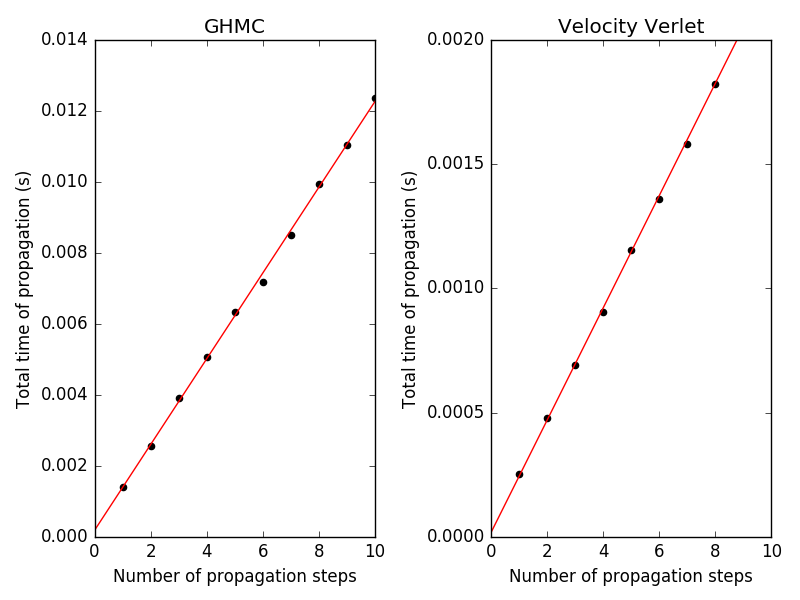

In [8]:
nsteps = np.array(range(1,11))

plt.clf()
fig, axarr = plt.subplots(1, 2)

nsteps = np.array(range(1,11))
x = np.linspace(0,10)
y_ghmc = regr_ghmc.predict(x.reshape(len(x),1))
y_vv= regr_vv.predict(x.reshape(len(x),1))

#y_ghmc= y_ghmc[:,0]
#print regr_ghmc.predict(x.reshape(len(x),1))

# GHMC
axarr[0].plot(x,y_ghmc,color='red')
axarr[0].scatter(nsteps,T_ghmc,color='k')
axarr[0].set_xlim((0,10))
axarr[0].set_ylim((0,0.014))
axarr[0].set_xlabel('Number of propagation steps')
axarr[0].set_ylabel('Total time of propagation (s)')
axarr[0].set_title('GHMC')
# velocity Verlet
axarr[1].plot(x,y_vv,color='red')
axarr[1].scatter(nsteps,T_vv,color='k')
axarr[1].set_xlim((0,10))
axarr[1].set_ylim((0,0.002))
axarr[1].set_xlabel('Number of propagation steps')
axarr[1].set_ylabel('Total time of propagation (s)')
axarr[1].set_title('Velocity Verlet')

plt.tight_layout()
plt.savefig('temp.png',format='png')
Image("temp.png")

# Example profile

In [9]:
filename = "GHMC/profile0_npert100_nprop1"       # The name of the output from profile
number=35                   # The number of functions whose times will be printed out
p = pstats.Stats(filename)
p.strip_dirs()
p.sort_stats('cumulative').print_stats(number)       # Printing my total time spent with function

Wed Sep 14 15:07:14 2016    GHMC/profile0_npert100_nprop1

         12487 function calls (12481 primitive calls) in 0.309 seconds

   Ordered by: cumulative time
   List reduced from 122 to 35 due to restriction <35>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.309    0.309 <string>:1(<module>)
        1    0.000    0.000    0.309    0.309 time_ncmc.py:48(profile_move)
        1    0.000    0.000    0.309    0.309 mcmc_samplers.py:135(move)
        1    0.000    0.000    0.309    0.309 mcmc_samplers.py:120(gen_label)
        1    0.000    0.000    0.309    0.309 saltswap.py:782(update)
        1    0.000    0.000    0.309    0.309 saltswap.py:388(attempt_identity_swap)
        1    0.001    0.001    0.293    0.293 saltswap.py:512(NCMC)
      101    0.000    0.000    0.158    0.002 openmm.py:5384(step)
      101    0.157    0.002    0.157    0.002 {_openmm.CustomIntegrator_step}
      102    0.001    0.000    0.068    0.001 op

<pstats.Stats instance at 0x1136b6cf8>